In [21]:
using CairoMakie 
using Roots 
using LinearAlgebra

#### Constants required for simulations #####

const N_L = 800
const Γ = 1.66
const xL = -0.5
const xR = 0.5
const small = 1e-12
const big = 1e12
const CFL = 0.35
const tf = 0.35

x = LinRange(xL,xR,N_L)
dx = (xR - xL) / N_L


function Lorentz(vx)
    v2 = vx*vx
    if v2 > 1 - small
        @warn "v^2 is close to 1.0; clamping"
        v2 = clamp(v2, small, 1 - small)
    end
    return clamp(sqrt(1/(1 - v2)), 1.0, big)
end


function prim_to_cons(u)
    n,vx,pg = u 
    γ = Lorentz(vx)
    e = pg/(Γ - 1) + n
    N_cons = n*γ
    Mx = (γ^2)*(e + pg) * vx
    E = (γ^2)*(e + pg) - pg
    if E < N_cons || E < Mx
        println("Physical constrains violated")
    end
    return [N_cons, Mx, E]
end

function prim_to_flux(u)
    n,vx,pg = u
    γ = Lorentz(vx)
    e = pg/(Γ - 1) + n
    N_cons = n*γ
    Mx = (γ^2)*(e + pg) * vx
    E = (γ^2)*(e + pg) - pg
    return [vx*N_cons, Mx*vx + pg , E*vx + pg*vx]
end

function cons_to_prim(U)
    N_cons , Mx , E = U
    function g(vx) 
        e_val = E - vx * Mx 
        n_val = N_cons * sqrt(1 - vx*vx) 
        P = (Γ - 1)*(e_val - n_val)
        return vx * ( E + P) - Mx
    end

    v_root = find_zero(g,(-1 + small, 1 - small), atol = small)
    if g(v_root) > small 
        println("roots are not in within tolerance ", [v_root, g(v_root)])
    end
    nr = N_cons/(Lorentz(v_root))
    er = E - v_root*Mx
    pg = (Γ - 1)*(er - nr)
    return [nr,v_root,pg]
end

function sound_speed(n,pg)
    e = pg/(Γ - 1) + n
    cs2 = (Γ*(Γ - 1)*(e - n))/ (n + Γ*(e - n))
    if cs2 > 1.0 - small || cs2 < small
        clamp(cs2,small, 1 - small)
    end
    return [cs2, sqrt(cs2)]
end 

function HLLE_bound_speeds(uL,uR)
    nL,vxL,pgL = uL 
    nR,vxR,pgR = uR 

    cs2L , csL = sound_speed(nL,pgL)
    cs2R , csR = sound_speed(nR,pgR)

    v_bar = 0.5*(vxL + vxR)
    cs_bar = 0.5*(csL + csR)

    λL = min(0.0, (v_bar - cs_bar) / (1 - v_bar*cs_bar), (vxL - csL) / ( 1 - vxL*csL) )
    λR = max(0.0, (v_bar + cs_bar) / (1 + v_bar*cs_bar), (vxR + csR) / ( 1 + vxR*csR) )

    return [λL , λR] 
end

function HLLE_flux(uL,uR)
    SL , SR = HLLE_bound_speeds(uL,uR)
    FL = prim_to_flux(uL) 
    FR = prim_to_flux(uR)
    UR = prim_to_cons(uR)
    UL = prim_to_cons(uL)

    if SL >= 0 
        return FL
    elseif SR <= 0
        return FR
    else 
        return (SR .* FL - SL .* FR + SL .* SR .* (UR .- UL)) ./ (SR .- SL)
    end
end

function maximum_signal(u)
    S_max = 0.0
    for i in 1:length(u)
        ni , vxi , pgi = u[i]
        cs2i , csi = sound_speed(ni,pgi)
        SL  = abs((vxi - csi) / (1 - vxi*csi))
        SR  = abs((vxi + csi) / (1 + vxi*csi))
        S_max = max(S_max, SL, SR)
    end
    return S_max
end


function minmod_slope_limiter_c(u)
    NC = length(u)
    uL_prim = deepcopy(u)
    uR_prim = deepcopy(u)
    #u_mid = deepcopy(u)

    for i in 1 : 3 
        for j in 2:NC - 1
            sp = u[j+1][i] - u[j][i]
            sm = u[j][i] - u[j-1][i]

            asp = abs(sp)
            asm = abs(sm)

            if sp*sm > 0.0
                if asp > asm
                    dU = 0.5*sm 
                else
                    dU = 0.5*sp
                end
            else
                dU = 0.0
            end

            uL_prim[j][i] = u[j][i] - dU
            uR_prim[j][i] = u[j][i] + dU
        end
    end
    return uL_prim , uR_prim
end


# Initial condition (Sod shock tube) - FIXED
function initial_condition(x)
    u_prim = Vector{Vector{Float64}}(undef, length(x))
    for i in 1:length(x)
        if x[i] < 0
            u_prim[i] =  [10.0,0.0,13*(1/3)]  #[1.0, 0.0, 1.0]        # # Left state
        else
            u_prim[i] = [1.0,0.0,(2/3)*(10^-6)] #[0.125, 0.0, 0.1]   # #   # Right state
        end
    end
    return u_prim
end

#[10.0,0.0,13*(1/3)] : (1.0,0.0,(2/3)*(10^-6))

# Initialize simulation
u_prim = initial_condition(x)

#println([u_prim[300][1],u_prim[300][2],u_prim[300][3] ])

U = [prim_to_cons(u) for u in u_prim] 
U_half_L = deepcopy(U)
U_half_R = deepcopy(U)
U_new = deepcopy(U);

Finished at t = 0.35 with step steps


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


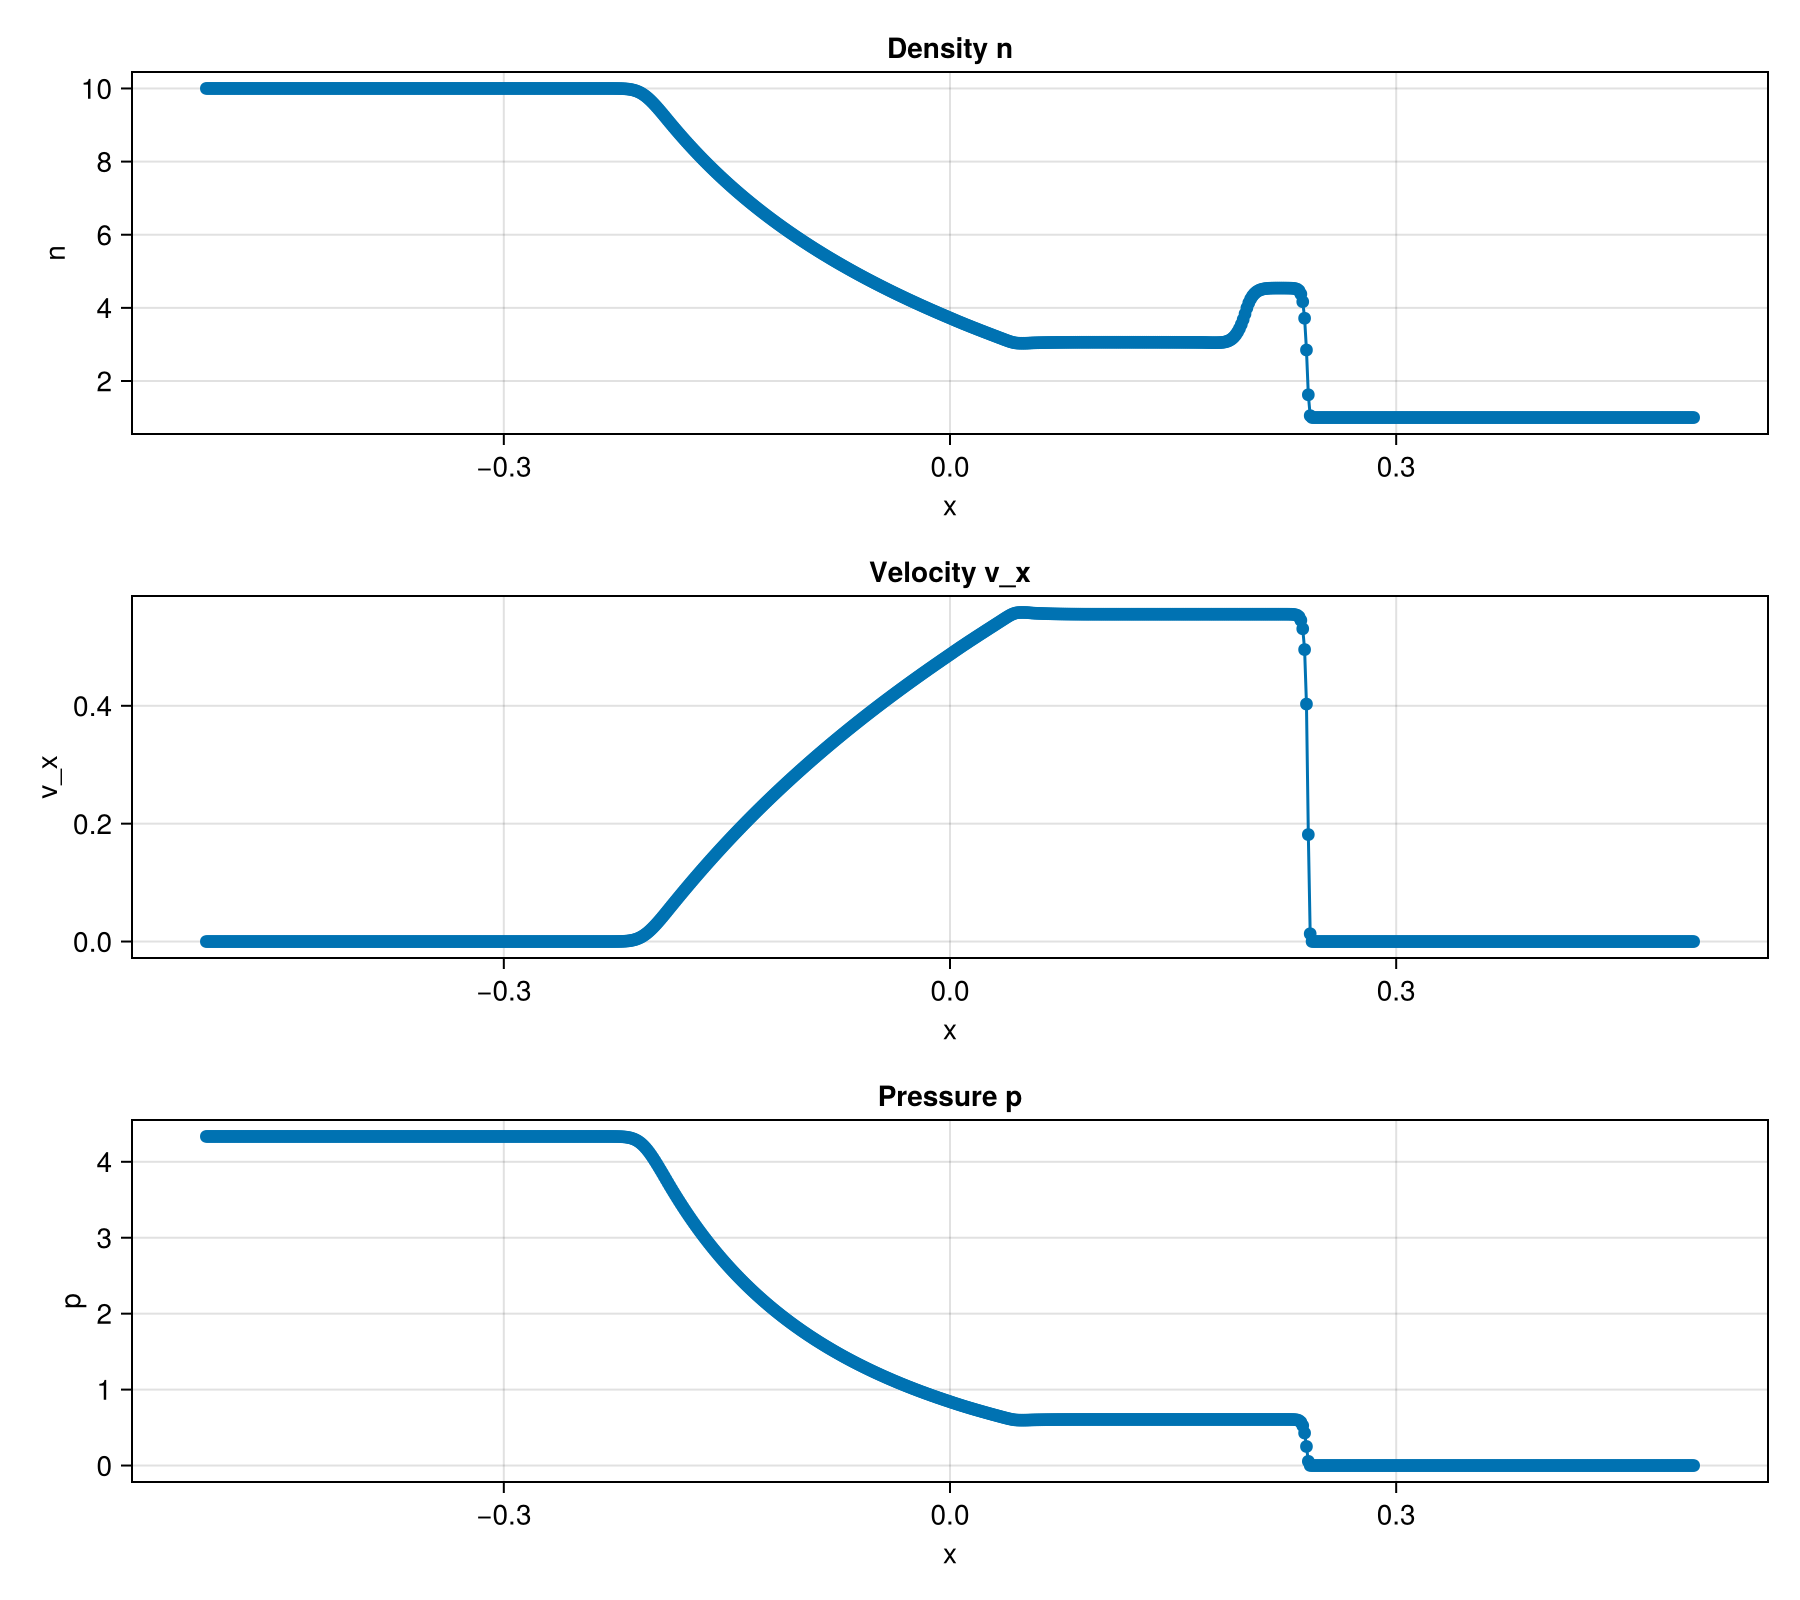

In [22]:
# --- Make dx consistent with the grid ---
dx = step(x)   # overrides previous dx definition; now matches LinRange

# ---------- Spatial RHS: dU/dt = -∂F/∂x ----------

function compute_rhs(U::Vector{Vector{Float64}})
    NC = length(U)

    # conservatives -> primitives
    u_prim = [cons_to_prim(U[i]) for i in 1:NC]

    # PLM reconstruction with minmod
    uL_prim, uR_prim = minmod_slope_limiter_c(u_prim)

    # Fluxes at cell faces: F[1] = left boundary, F[NC+1] = right boundary
    F_face = [zeros(3) for _ in 1:(NC+1)]

    # Outflow (zero-gradient) BCs: flux = physical flux of boundary cell
    F_face[1]      = prim_to_flux(u_prim[1])
    F_face[NC + 1] = prim_to_flux(u_prim[NC])

    # Interior faces via HLLE
    for j in 1:(NC-1)
        F_face[j + 1] = HLLE_flux(uR_prim[j], uL_prim[j + 1])
    end

    # Divergence of flux
    invdx = 1.0 / dx
    dUdt = [zeros(3) for _ in 1:NC]

    for j in 1:NC
        Fjm = F_face[j]
        Fjp = F_face[j + 1]
        for m in 1:3
            dUdt[j][m] = -(Fjp[m] - Fjm[m]) * invdx
        end
    end

    return dUdt
end

# ---------- RK4 single step ----------

function rk4_step!(U::Vector{Vector{Float64}}, dt::Float64)
    NC = length(U)

    k1 = compute_rhs(U)

    U1 = [U[i] .+ 0.5 * dt .* k1[i] for i in 1:NC]
    k2 = compute_rhs(U1)

    U2 = [U[i] .+ 0.5 * dt .* k2[i] for i in 1:NC]
    k3 = compute_rhs(U2)

    U3 = [U[i] .+ dt .* k3[i] for i in 1:NC]
    k4 = compute_rhs(U3)

    for i in 1:NC
        U[i] .= U[i] .+ (dt/6.0) .* (k1[i] .+ 2.0 .* k2[i] .+ 2.0 .* k3[i] .+ k4[i])
    end

    return nothing
end

# ---------- CFL time step ----------

function compute_dt(U::Vector{Vector{Float64}})
    # Need primitives for wavespeeds
    u_prim = [cons_to_prim(U[i]) for i in 1:length(U)]
    Smax = maximum_signal(u_prim)
    Smax == 0.0 && return tf  # fully static (should not happen here)
    return CFL * dx / Smax
end

# ---------- Time evolution loop (RK4) ----------

t = 0.0
nsteps = 0

while t < tf - 1e-12
    dt = compute_dt(U)
    if t + dt > tf
        dt = tf - t
    end

    rk4_step!(U, dt)

    t += dt
    nsteps += 1
end
println("Finished at t = $t with $step steps")

# Recover primitives at final time
u_final = [cons_to_prim(U[i]) for i in 1:length(U)]

nR_final  = [u[1] for u in u_final]
vxR_final = [u[2] for u in u_final]
pgR_final = [u[3] for u in u_final]

# ---------- Simple CairoMakie plots (optional) ----------

fig = Figure(resolution=(900, 800))

ax1 = Axis(fig[1, 1], title = "Density n", xlabel = "x", ylabel = "n")
scatterlines!(ax1, x, nR_final)

ax2 = Axis(fig[2, 1], title = "Velocity v_x", xlabel = "x", ylabel = "v_x")
scatterlines!(ax2, x, vxR_final)

ax3 = Axis(fig[3, 1], title = "Pressure p", xlabel = "x", ylabel = "p")
scatterlines!(ax3, x, pgR_final)

fig


Finished at t = 0.35  with 799 steps


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


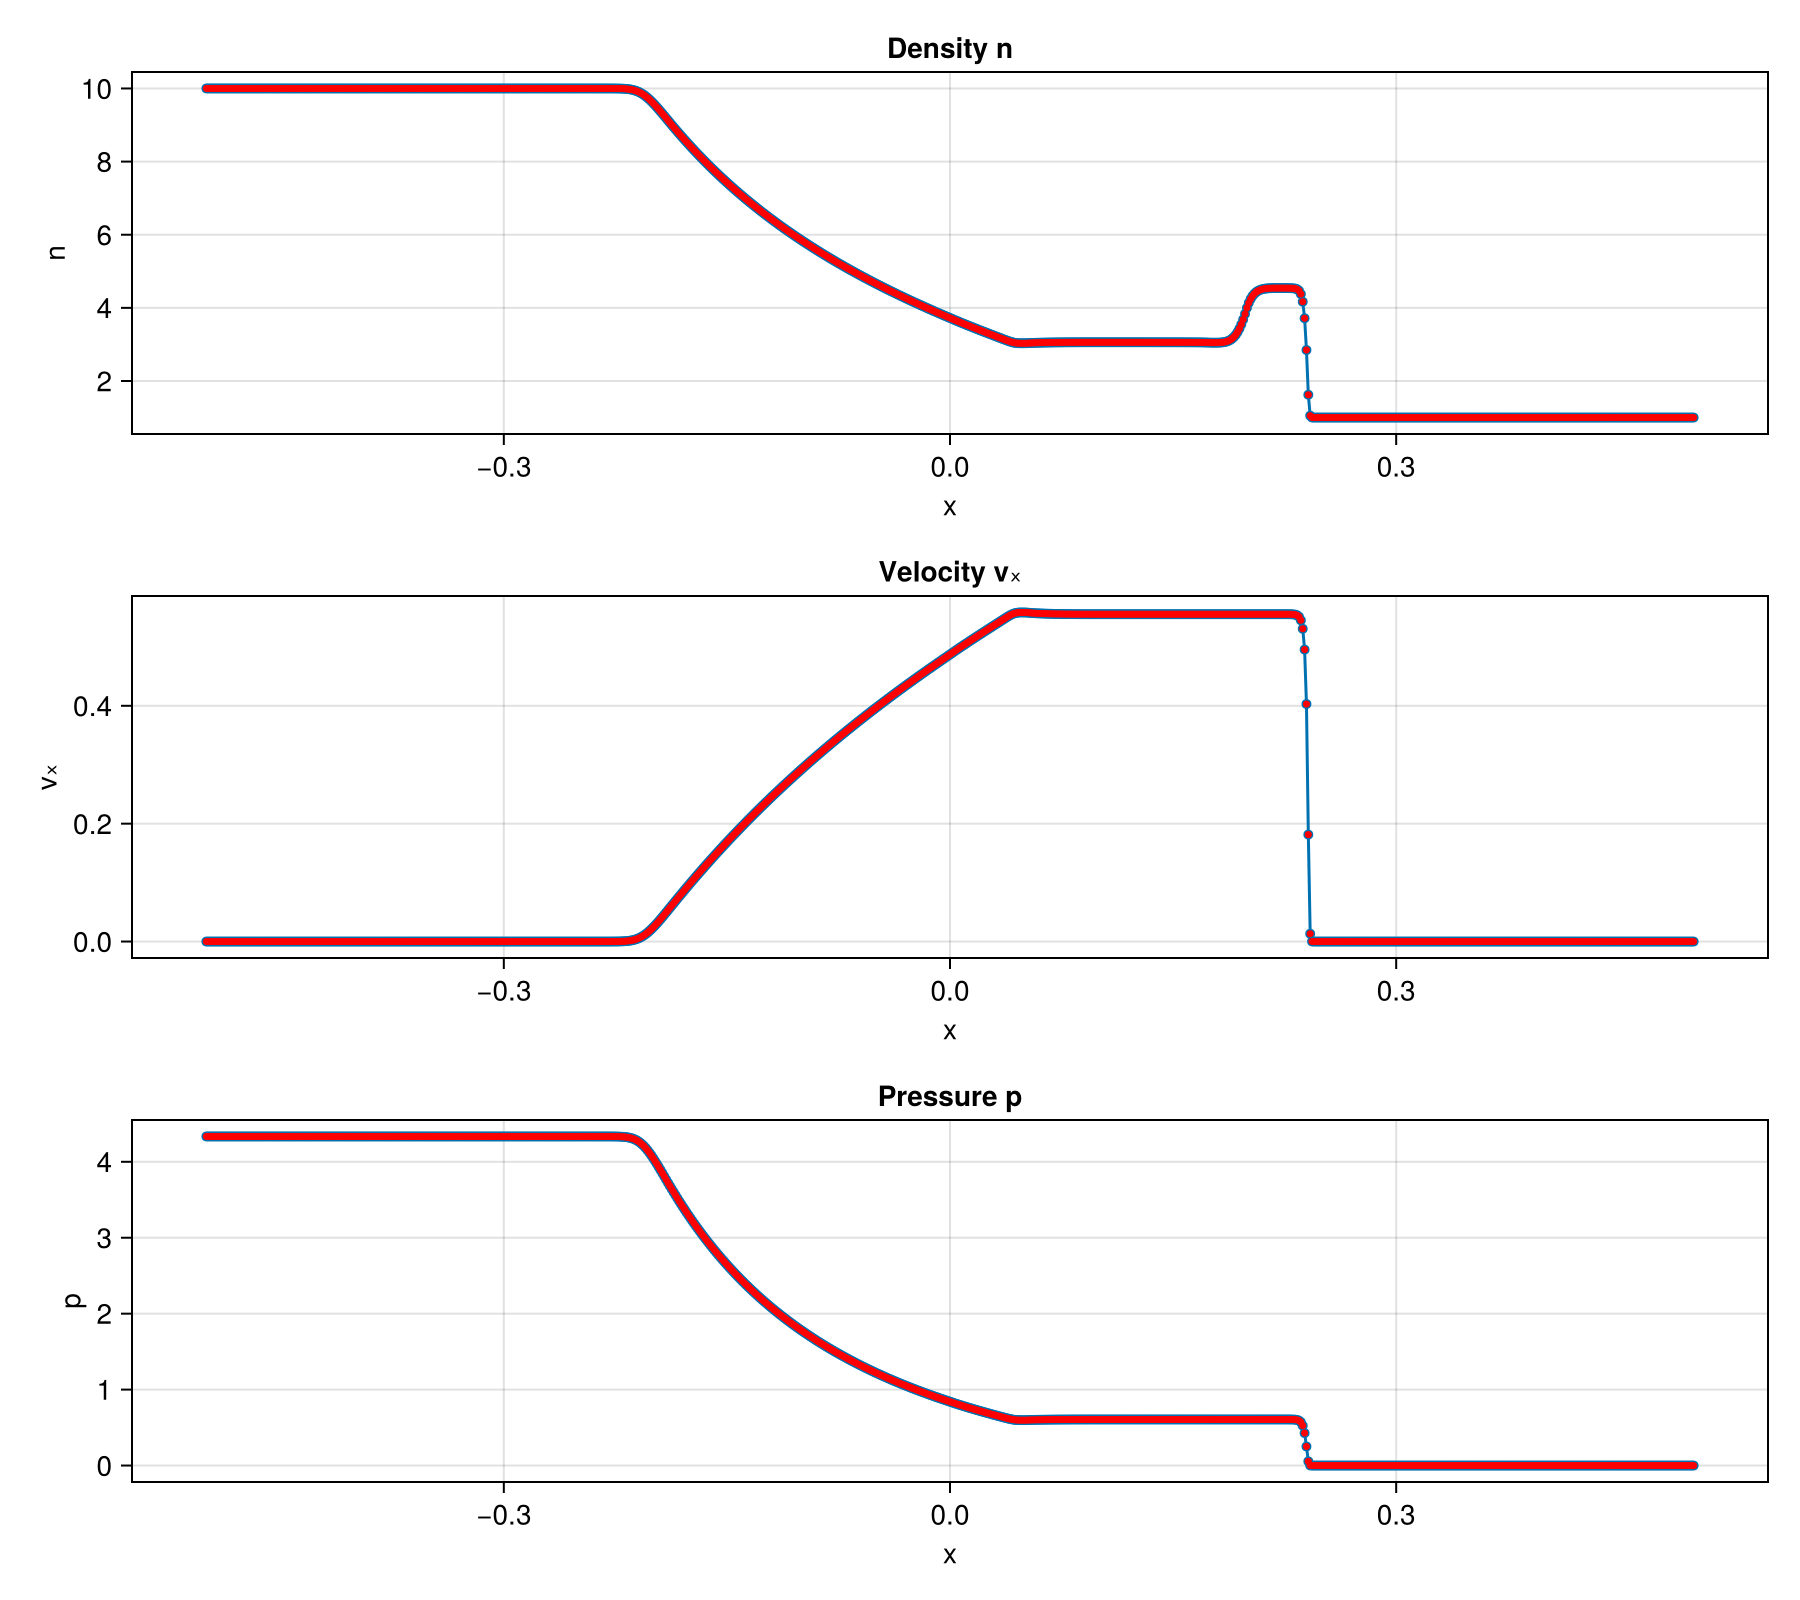

In [23]:
############################################################
# 1D Special Relativistic Hydro: Sod Tube
# HLLE + PLM(minmod) in space, SSPRK in time
############################################################

using CairoMakie
using Roots
using LinearAlgebra
using OrdinaryDiffEqSSPRK           # SSPRK time steppers
import OrdinaryDiffEqSSPRK: ODEProblem, solve, SSPRK53_2N1  # explicit import (as in ClimaCore/Trixi tutorials)

#### Constants required for simulations #####

const N_L   = 800
const Γ     = 1.66
const xL    = -0.5
const xR    =  0.5
const small = 1e-12
const big   = 1e12
const CFL   = 0.35
const tf    = 0.35

# Grid
x  = LinRange(xL, xR, N_L)
dx = step(x)   # spacing of the LinRange

############################################################
#    Primitive ↔ Conservative and Fluxes
#    u_prim = [n, vx, p]
#    U_cons = [N, Mx, E]
############################################################

function Lorentz(vx)
    v2 = vx * vx
    if v2 > 1 - small
        @warn "v^2 is close to 1.0; clamping"
        v2 = clamp(v2, small, 1 - small)
    end
    return clamp(sqrt(1 / (1 - v2)), 1.0, big)
end

function prim_to_cons(u::AbstractVector{<:Real})
    n, vx, pg = u
    γ  = Lorentz(vx)
    e  = pg / (Γ - 1) + n
    Nc = n * γ
    Mx = (γ^2) * (e + pg) * vx
    E  = (γ^2) * (e + pg) - pg
    if E < Nc || E < Mx
        @warn "Physical constraints violated: E < N or E < Mx"
    end
    return [Nc, Mx, E]
end

function prim_to_flux(u::AbstractVector{<:Real})
    n, vx, pg = u
    γ  = Lorentz(vx)
    e  = pg / (Γ - 1) + n
    Nc = n * γ
    Mx = (γ^2) * (e + pg) * vx
    E  = (γ^2) * (e + pg) - pg
    return [vx * Nc, Mx * vx + pg, E * vx + pg * vx]
end

function cons_to_prim(U::AbstractVector{<:Real})
    N_cons, Mx, E = U

    # root find for vx from momentum equation
    function g(vx)
        e_val = E - vx * Mx
        n_val = N_cons * sqrt(1 - vx * vx)
        P     = (Γ - 1) * (e_val - n_val)
        return vx * (E + P) - Mx
    end

    v_root = find_zero(g, (-1 + small, 1 - small), atol = small)

    if abs(g(v_root)) > 1e-8
        @warn "Velocity root not within tolerance" v_root g(v_root)
    end

    γ  = Lorentz(v_root)
    nr = N_cons / γ
    er = E - v_root * Mx
    pg = (Γ - 1) * (er - nr)
    return [nr, v_root, pg]
end

############################################################
#    Sound speed and wave speeds
############################################################

function sound_speed(n, pg)
    e   = pg / (Γ - 1) + n
    cs2 = (Γ * (Γ - 1) * (e - n)) / (n + Γ * (e - n))
    if cs2 > 1.0 - small || cs2 < small
        cs2 = clamp(cs2, small, 1 - small)
    end
    return (cs2, sqrt(cs2))
end

function HLLE_bound_speeds(uL::AbstractVector, uR::AbstractVector)
    nL, vxL, pgL = uL
    nR, vxR, pgR = uR

    _, csL = sound_speed(nL, pgL)
    _, csR = sound_speed(nR, pgR)

    v_bar  = 0.5 * (vxL + vxR)
    cs_bar = 0.5 * (csL + csR)

    λL = min(0.0,
             (v_bar - cs_bar) / (1 - v_bar * cs_bar),
             (vxL  - csL)     / (1 - vxL * csL))

    λR = max(0.0,
             (v_bar + cs_bar) / (1 + v_bar * cs_bar),
             (vxR  + csR)     / (1 + vxR * csR))

    return (λL, λR)
end

function HLLE_flux(uL::AbstractVector, uR::AbstractVector)
    SL, SR = HLLE_bound_speeds(uL, uR)
    FL = prim_to_flux(uL)
    FR = prim_to_flux(uR)
    UL = prim_to_cons(uL)
    UR = prim_to_cons(uR)

    if SL >= 0
        return FL
    elseif SR <= 0
        return FR
    else
        num = SR .* FL .- SL .* FR .+ SL .* SR .* (UR .- UL)
        den = SR - SL
        return num ./ den
    end
end

function maximum_signal(u_prim::Vector{Vector{Float64}})
    S_max = 0.0
    for i in 1:length(u_prim)
        ni, vxi, pgi = u_prim[i]
        _, csi = sound_speed(ni, pgi)
        SL  = abs((vxi - csi) / (1 - vxi * csi))
        SR  = abs((vxi + csi) / (1 + vxi * csi))
        S_max = max(S_max, SL, SR)
    end
    return S_max
end

############################################################
#    Minmod slope limiter (PLM reconstruction)
############################################################

function minmod_slope_limiter_c(u::Vector{Vector{Float64}})
    NC      = length(u)
    uL_prim = deepcopy(u)
    uR_prim = deepcopy(u)

    # loop over primitive components: n, vx, p
    for i in 1:3
        for j in 2:NC-1
            sp = u[j+1][i] - u[j][i]
            sm = u[j][i]   - u[j-1][i]

            asp = abs(sp)
            asm = abs(sm)

            if sp * sm > 0.0
                if asp > asm
                    dU = 0.5 * sm
                else
                    dU = 0.5 * sp
                end
            else
                dU = 0.0
            end

            uL_prim[j][i] = u[j][i] - dU
            uR_prim[j][i] = u[j][i] + dU
        end
    end

    return uL_prim, uR_prim
end

############################################################
#    Initial condition (Sod shock tube)
############################################################

function initial_condition(x)
    u_prim = Vector{Vector{Float64}}(undef, length(x))
    for i in 1:length(x)
        if x[i] < 0
            # Left state
            u_prim[i] =  [10.0,0.0,13*(1/3)]       #[1.0, 0.0, 1.0]
        else
            # Right state
            u_prim[i] =  [1.0,0.0,(2/3)*(10^-6)]   #[0.125, 0.0, 0.1]
        end
    end
    return u_prim
end

############################################################
#    Spatial RHS: dU/dt = - ∂F/∂x
#    U is a 3×N_L matrix: rows = [N; Mx; E], cols = cells
############################################################

function compute_rhs!(dU::AbstractMatrix, U::AbstractMatrix)
    NC = size(U, 2)

    # conservatives -> primitives (vector-of-vectors for limiter)
    u_prim = Vector{Vector{Float64}}(undef, NC)
    for j in 1:NC
        u_prim[j] = cons_to_prim(@view U[:, j])
    end

    # PLM reconstruction with minmod limiter
    uL_prim, uR_prim = minmod_slope_limiter_c(u_prim)

    # Fluxes at cell faces F_face[:, 1] ... F_face[:, NC+1]
    F_face = zeros(3, NC + 1)

    # Outflow BC: flux at boundary = physical flux of boundary cell
    F_face[:, 1]      .= prim_to_flux(u_prim[1])
    F_face[:, NC + 1] .= prim_to_flux(u_prim[NC])

    # Interior faces via HLLE
    for j in 1:(NC - 1)
        F_face[:, j + 1] .= HLLE_flux(uR_prim[j], uL_prim[j + 1])
    end

    # Divergence of flux
    invdx = 1.0 / dx
    for j in 1:NC
        @inbounds dU[:, j] .= -(F_face[:, j + 1] .- F_face[:, j]) .* invdx
    end

    return nothing
end

# SciML-compatible in-place RHS: dU/dt = semi_rhs!(dU, U, p, t)
function semi_rhs!(dU, U, p, t)
    compute_rhs!(dU, U)
    return nothing
end

############################################################
#    Build problem, choose SSPRK, evolve
############################################################

# primitives and conservatives at t=0
u_prim0 = initial_condition(x)

U0 = zeros(3, N_L)
for j in 1:N_L
    U0[:, j] .= prim_to_cons(u_prim0[j])
end

tspan = (0.0, tf)

# Choose SSPRK algorithm (fixed-step, good for hyperbolic PDEs)
#alg = SSPRK53_2N1()
alg = SSPRK53_H()

# Simple CFL choice: max wavespeed ≤ 1 ⇒ dt = CFL * dx is safe
dt = CFL * dx

prob = ODEProblem(semi_rhs!, U0, tspan)
sol  = solve(prob, alg; dt = dt, adaptive = false)

println("Finished at t = ", sol.t[end], "  with ", length(sol.t) - 1, " steps")

############################################################
#    Post-process: primitives at final time and plots
############################################################

U_final = sol.u[end]

n_final  = similar(x)
vx_final = similar(x)
pg_final = similar(x)

for j in 1:N_L
    u = cons_to_prim(@view U_final[:, j])
    n_final[j]  = u[1]
    vx_final[j] = u[2]
    pg_final[j] = u[3]
end

fig = Figure(resolution = (900, 800))

ax1 = Axis(fig[1, 1], title = "Density n",   xlabel = "x", ylabel = "n")
scatterlines!(ax1, x, n_final, markersize = 7.0)
scatter!(ax1, x, nR_final, markersize = 5.0, color =:red)

ax2 = Axis(fig[2, 1], title = "Velocity vₓ", xlabel = "x", ylabel = "vₓ")
scatterlines!(ax2, x, vx_final, markersize = 7.0)
scatter!(ax2, x, vxR_final, markersize = 5.0, color =:red)

ax3 = Axis(fig[3, 1], title = "Pressure p",  xlabel = "x", ylabel = "p")
scatterlines!(ax3, x, pg_final, markersize = 7.0)
scatter!(ax3, x, pgR_final, markersize = 5.0, color =:red)



fig
# save("srhd_sod_ssprk.png", fig)
